# Fully saturated TWFE の解釈

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

figsize=(10, 5)

In [40]:
path = '../../data/processed/fully_saturated/fs_homo_beta.csv'
beta_df = pd.read_csv(path)
path = '../../data/processed/df_filtered.xlsx'
df = pd.read_excel(path)

In [72]:
len(beta_df)

4356

Text(0, 0.5, '%')

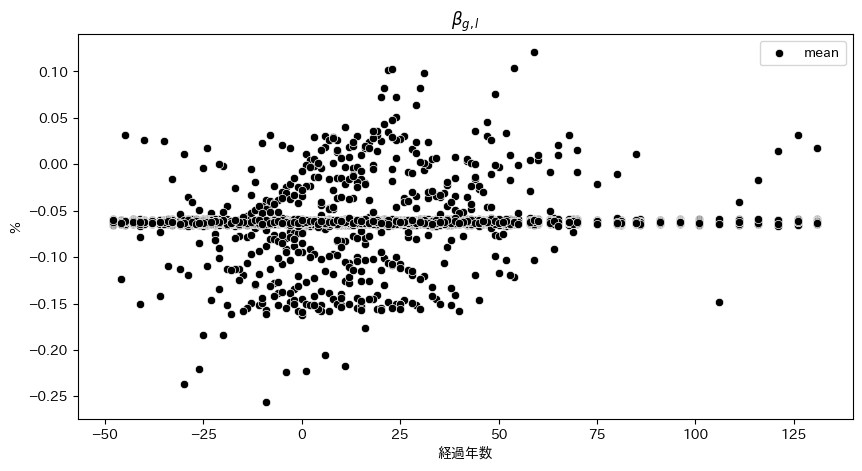

In [41]:
fig, ax = plt.subplots(figsize=figsize)
sns.scatterplot(x='time_since_treatment', y='mean', data=beta_df, ax=ax, color='black', label='mean')
ax.set_title('$β_{g, l}$')
ax.set_xlabel('経過年数')
ax.set_ylabel('%')

In [64]:
bridge_years = df['bridge_year'].unique()
bridge_years.min()

0

In [67]:
bridge_year = 1889
time_since_treatments = df.query(f'bridge_year == {bridge_year}')['time_since_treatment'].unique()
time_since_treatments.min(), time_since_treatments.max()

(81, 131)

In [70]:
class FullySaturatedPlotter():
    def __init__(self, df, beta_df, bridge_year):
        self.df = df
        self.beta_df = beta_df
        self.bridge_year = bridge_year

    def fully_saturated_plot(self):
        time_since_treatments = self.df.query(f'bridge_year == {self.bridge_year}')['time_since_treatment'].unique()
        query = f'bridge_year == {self.bridge_year} and time_since_treatment >= {time_since_treatments.min()} and time_since_treatment <= {time_since_treatments.max()}'
        df_g = self.beta_df.query(query).sort_values('time_since_treatment')
        fig, ax = plt.subplots(figsize=figsize)
        sns.scatterplot(x='time_since_treatment', y='mean', data=df_g, color='black', ax=ax)
        ax.fill_between(
            x='time_since_treatment',
            y1='hdi_2.5%',
            y2='hdi_97.5%',
            data=df_g,
            color='black',
            alpha=0.3
        )
        ax.axhline(y=0, color='black', ls=':')
        ax.axvline(x=0, color='black', ls=':')
        ax.set_title(f'{self.bridge_year}')
        ax.set_xlabel('経過年数')
        ax.set_ylabel('')

/tmp/ipykernel_6682/573648645.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


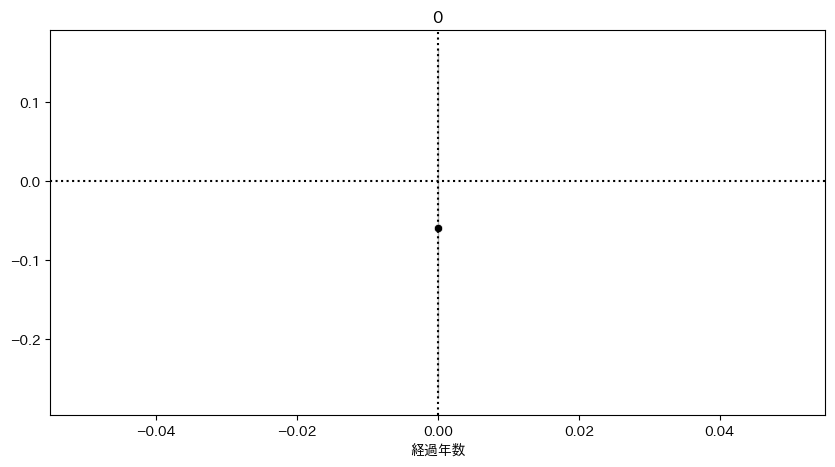

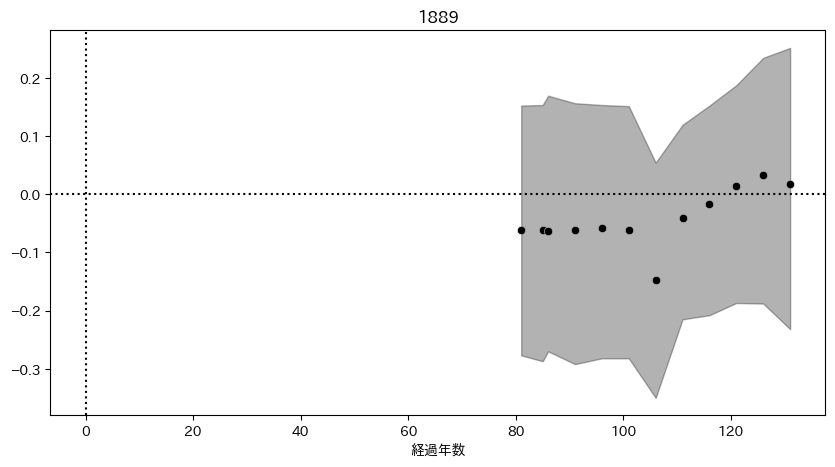

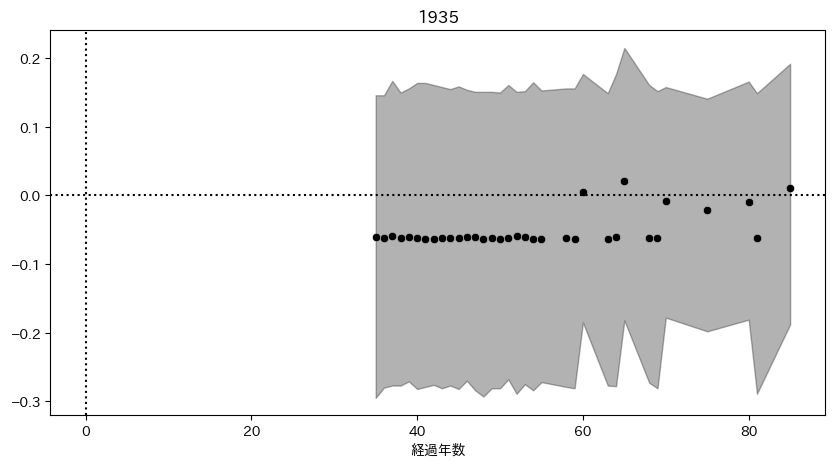

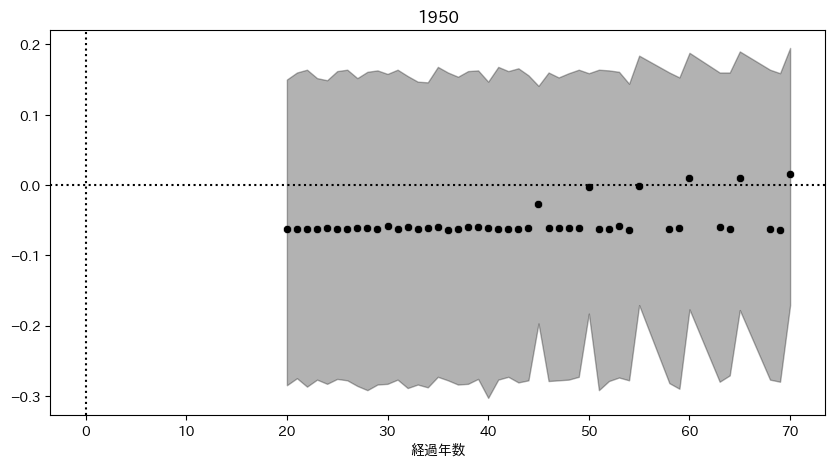

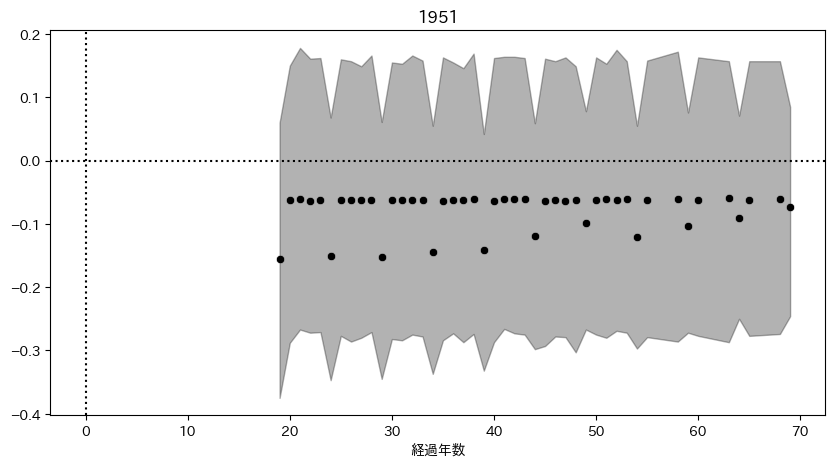

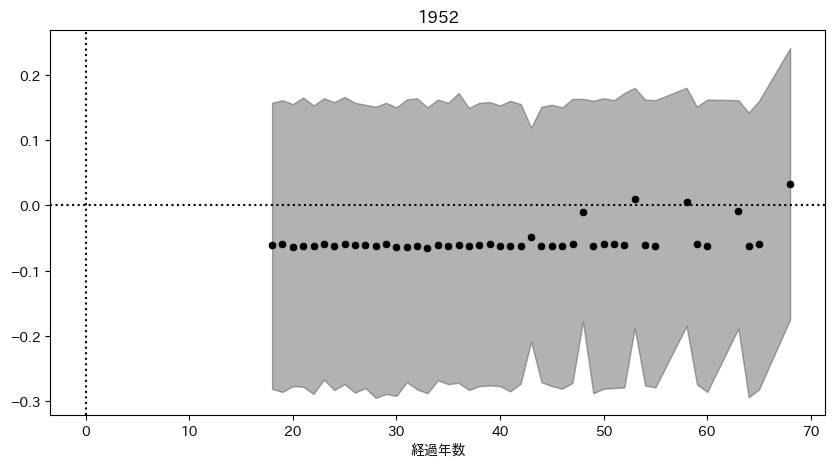

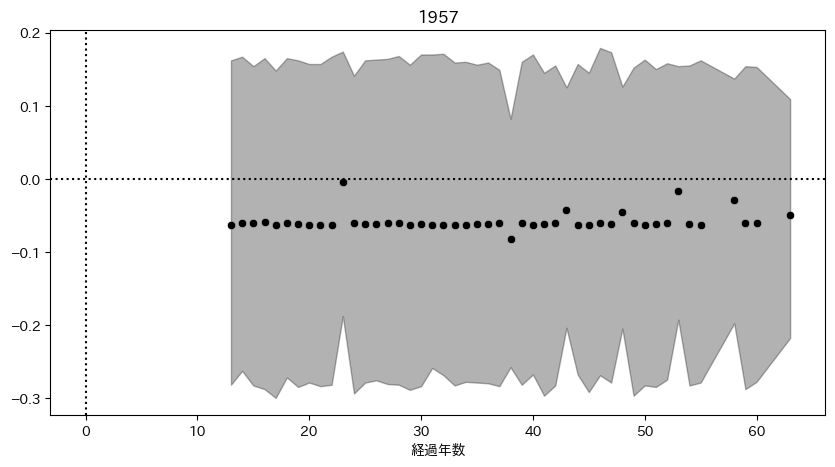

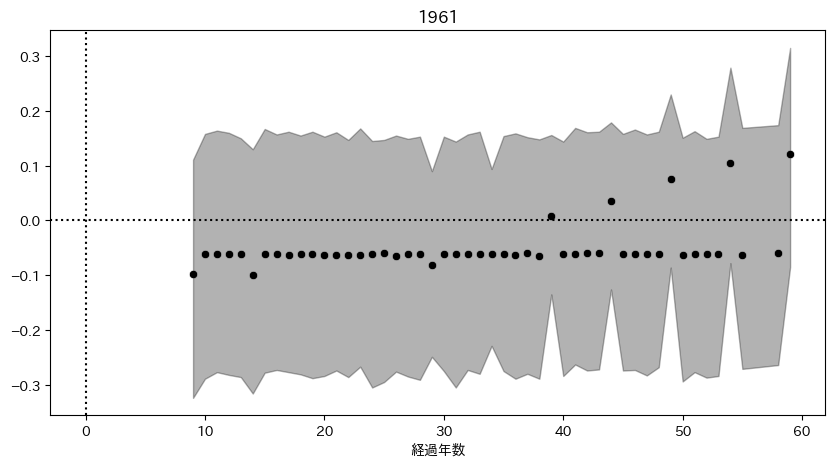

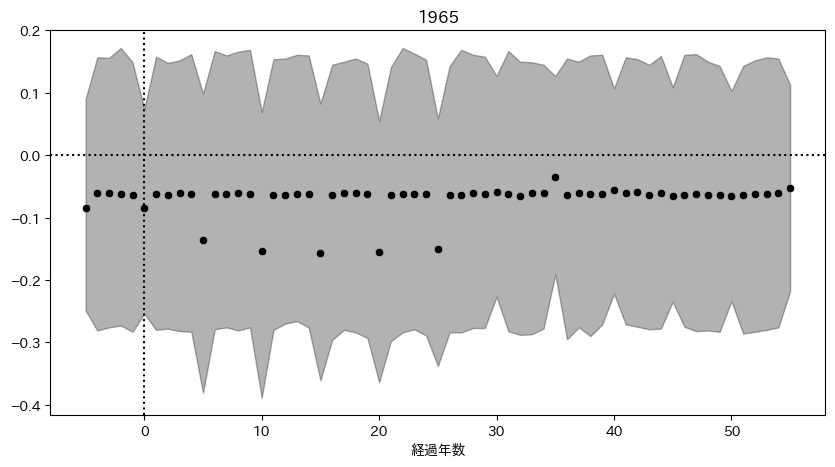

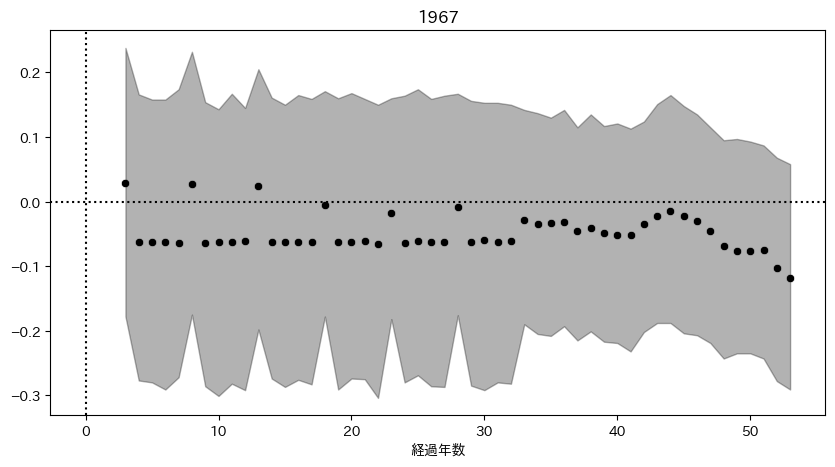

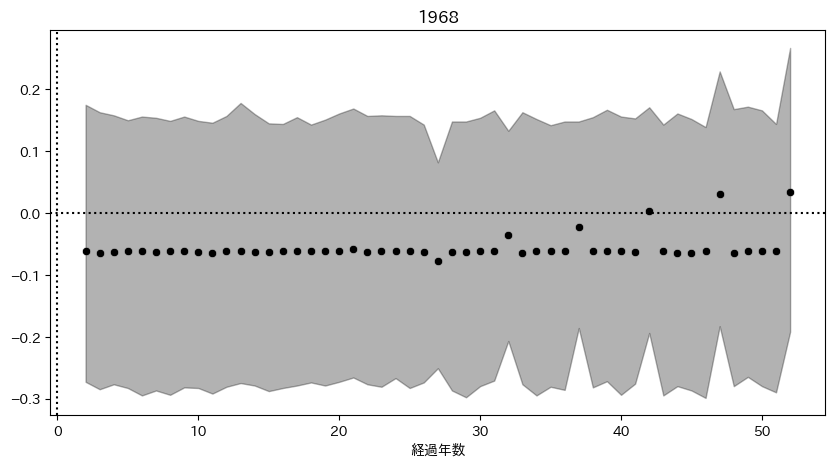

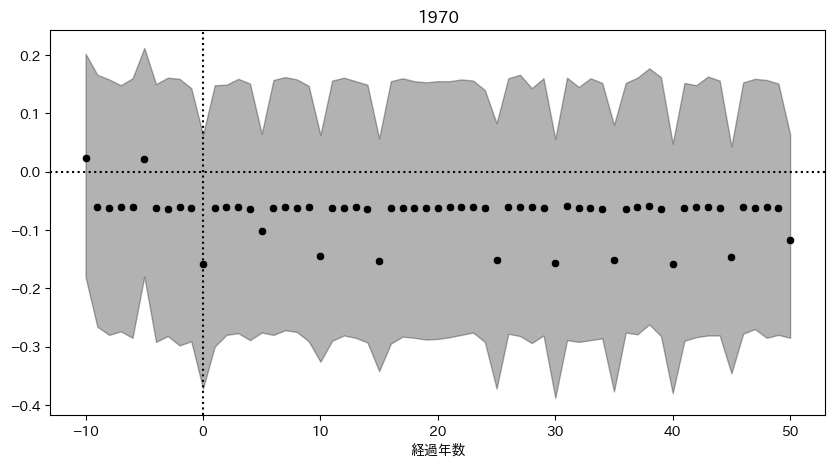

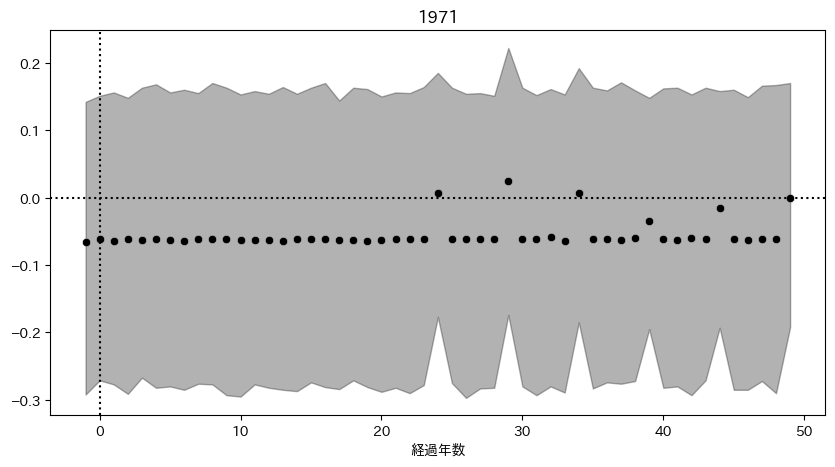

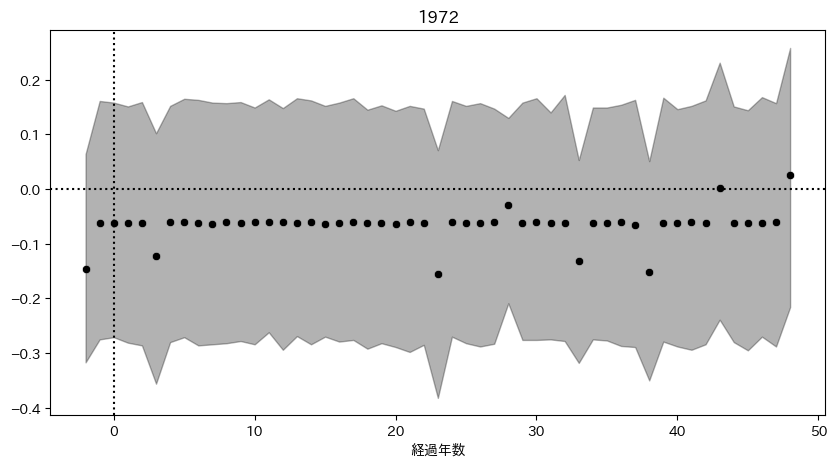

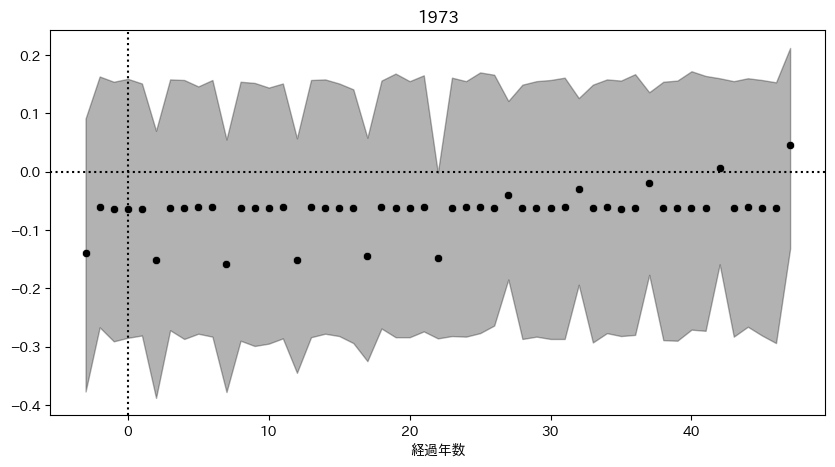

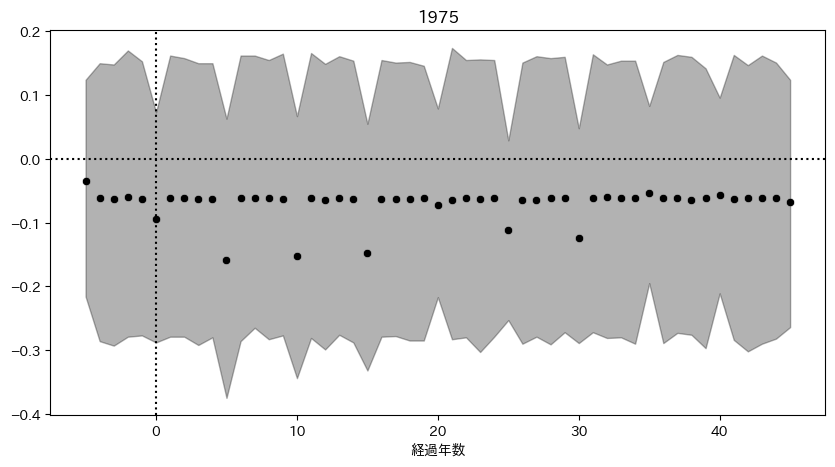

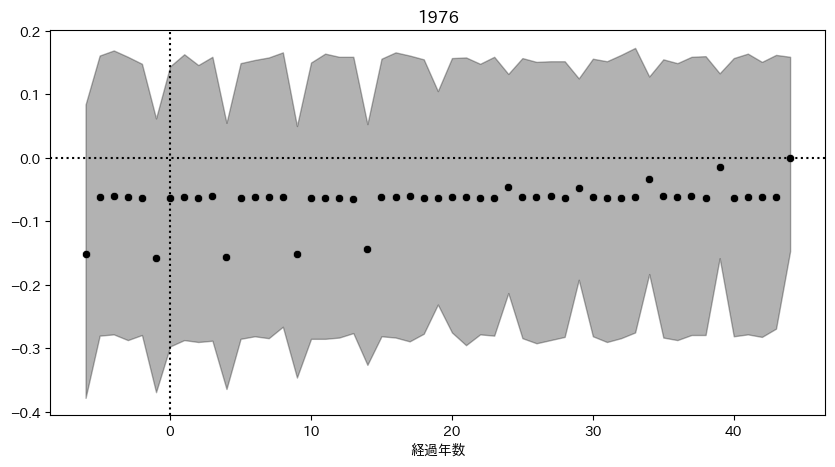

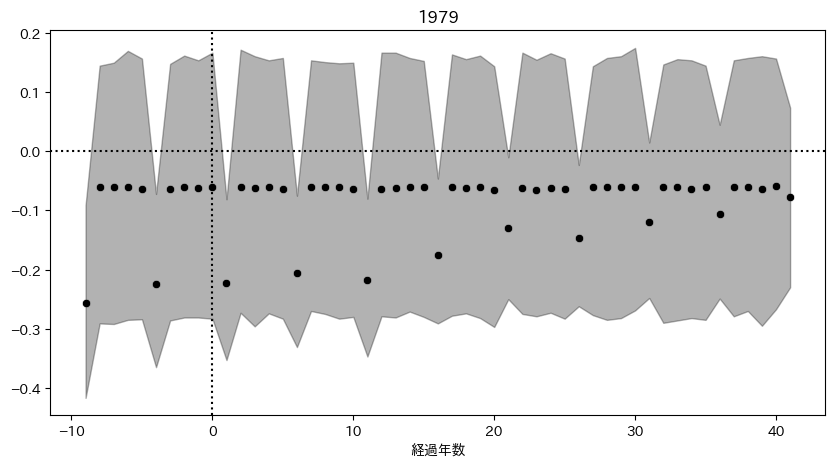

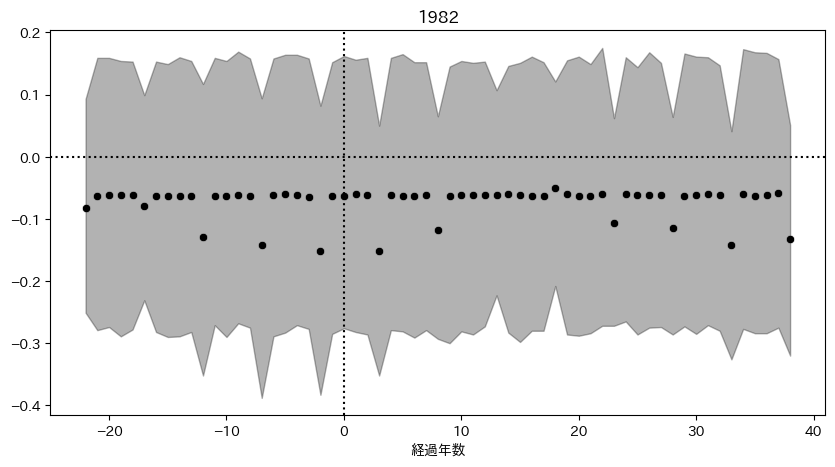

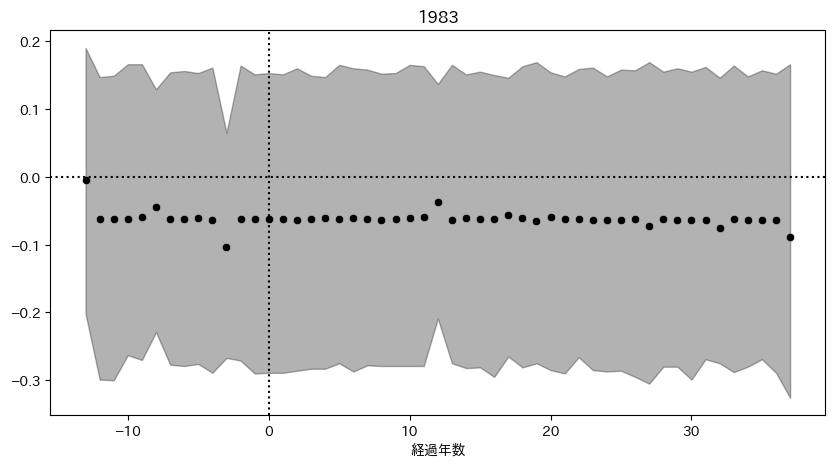

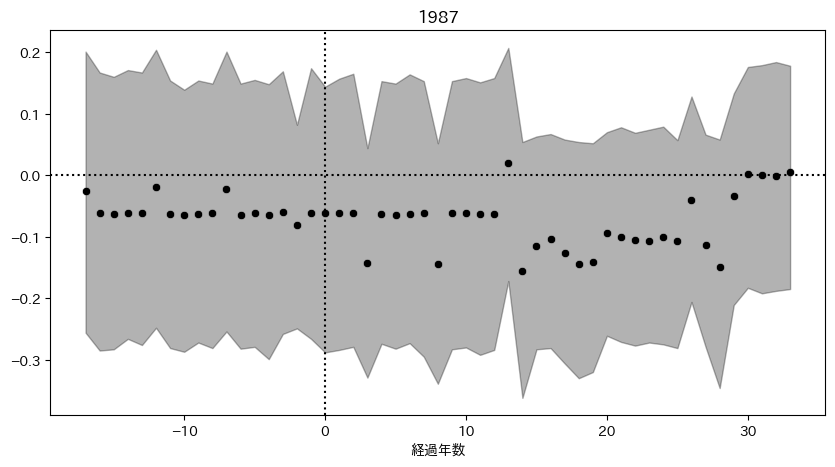

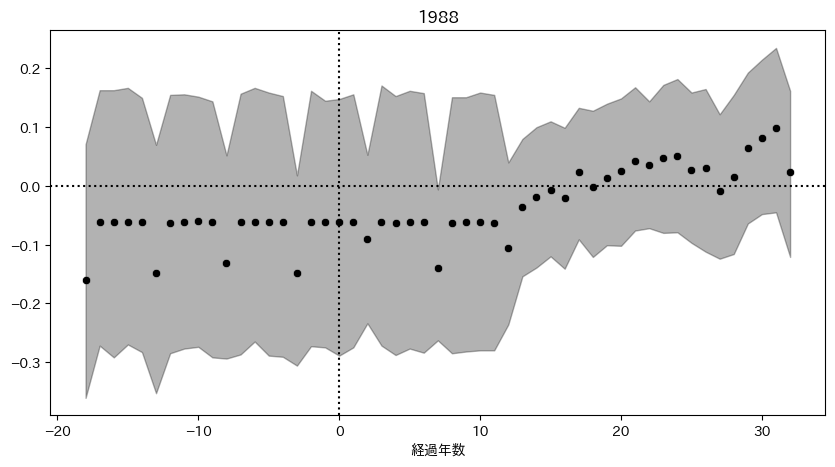

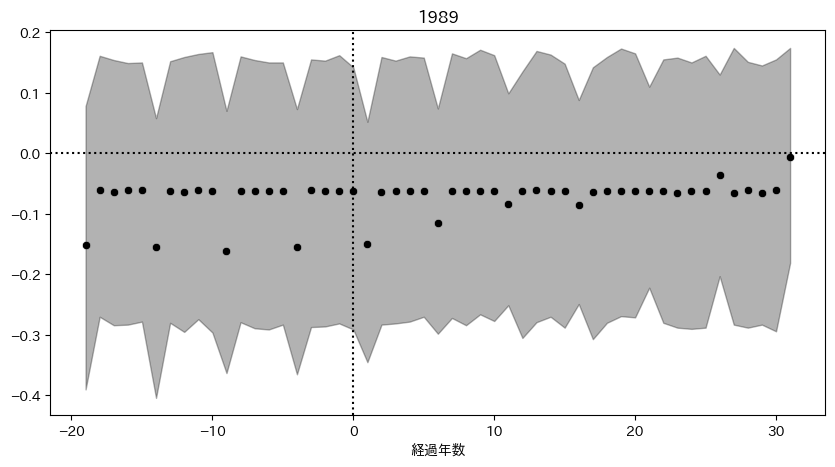

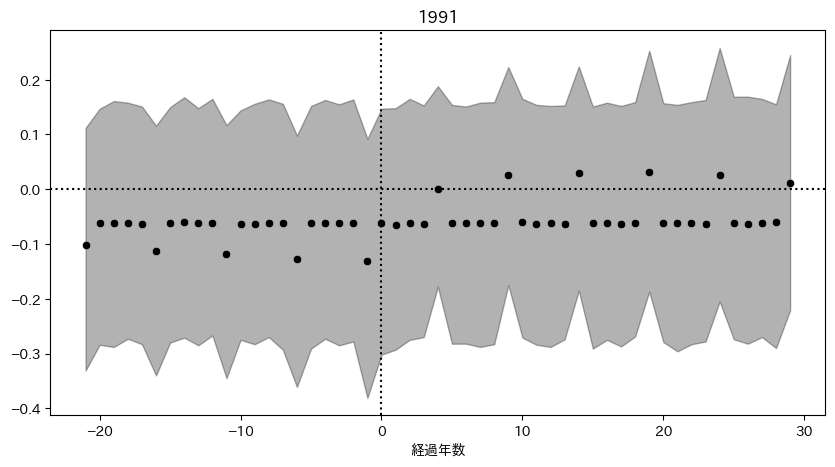

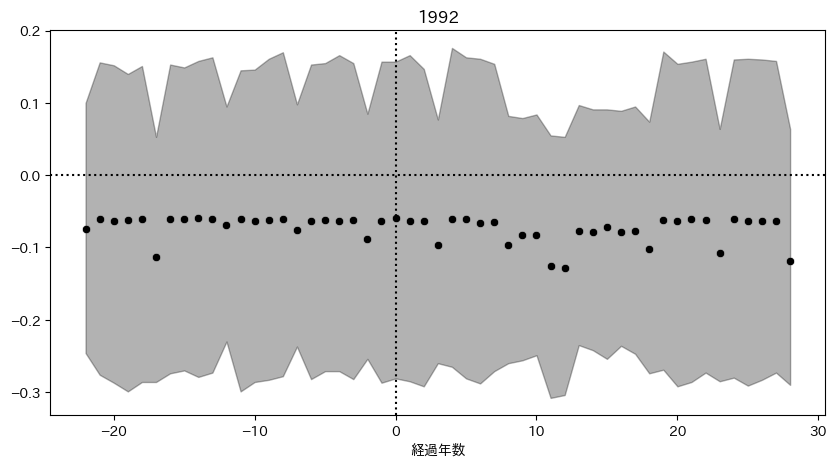

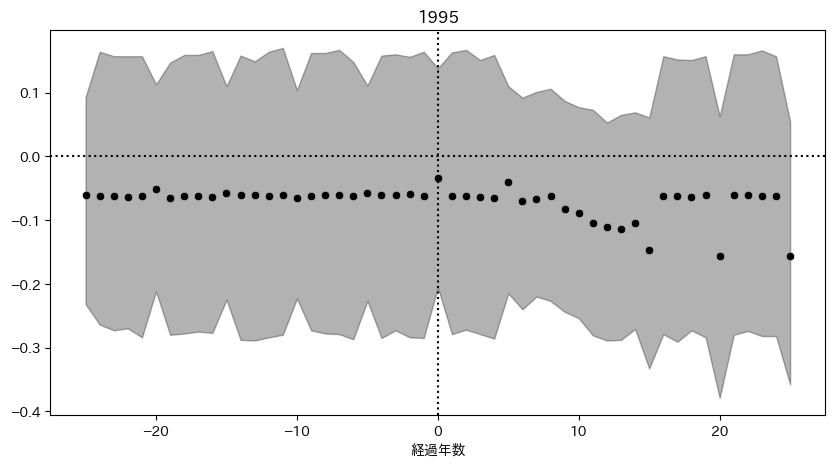

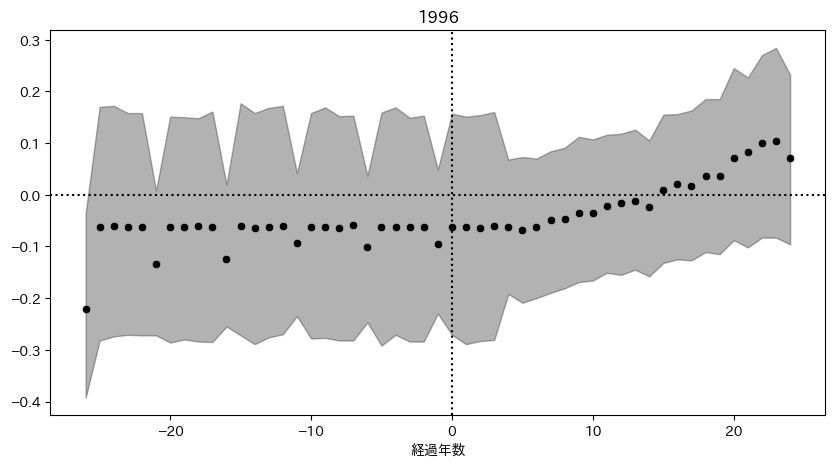

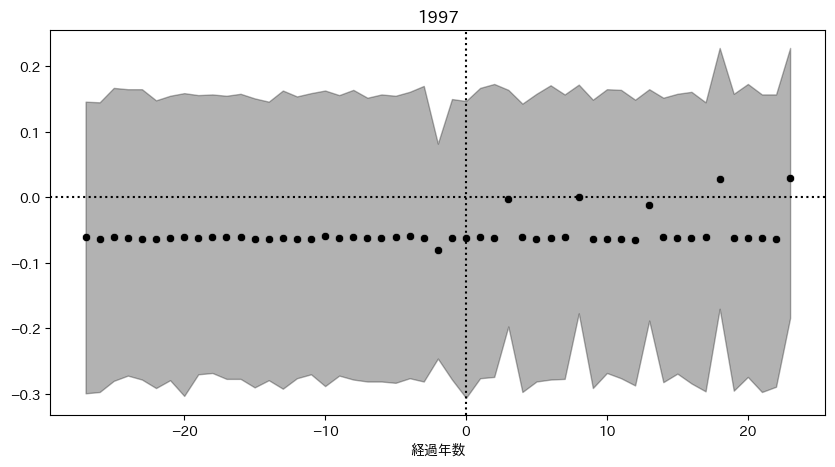

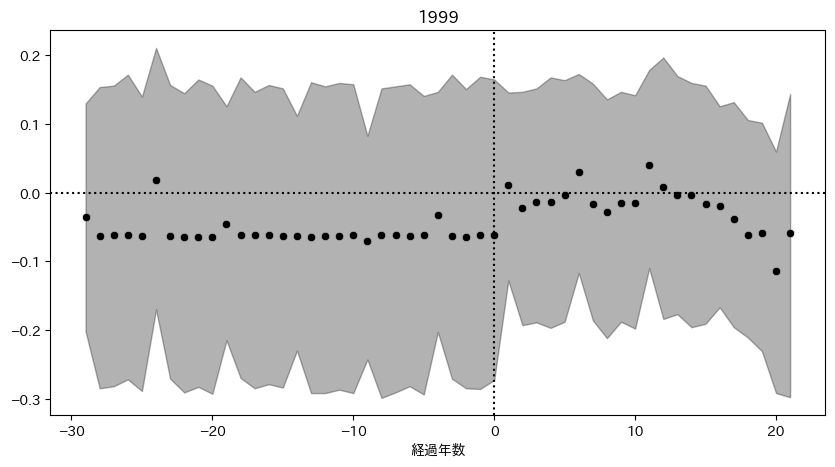

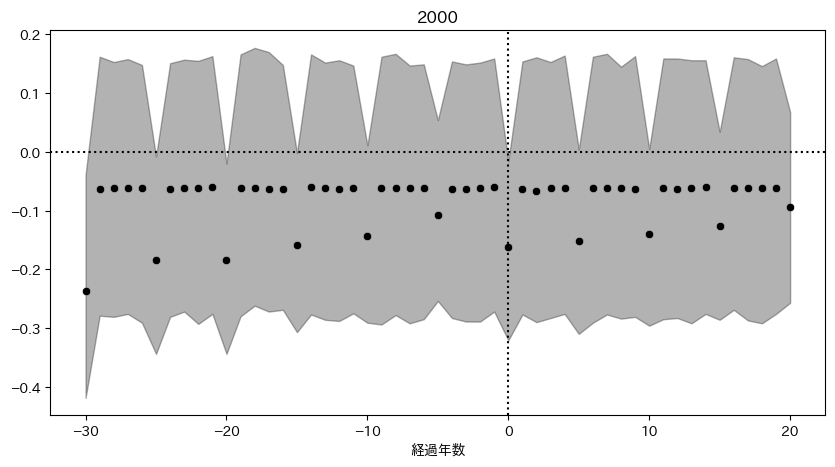

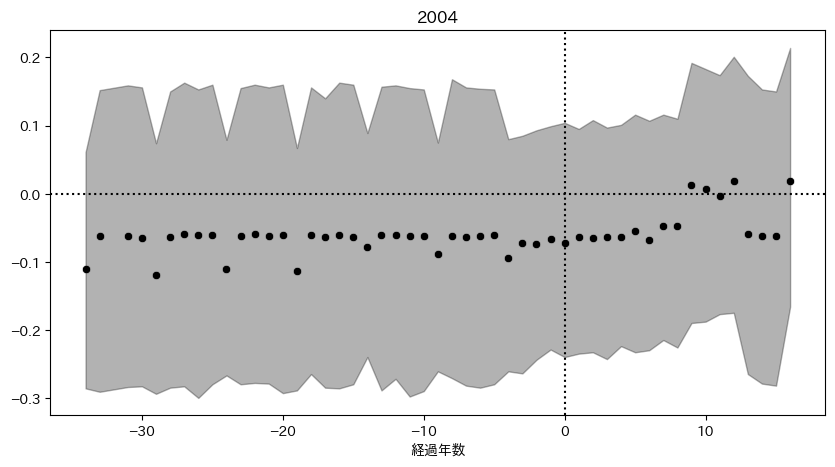

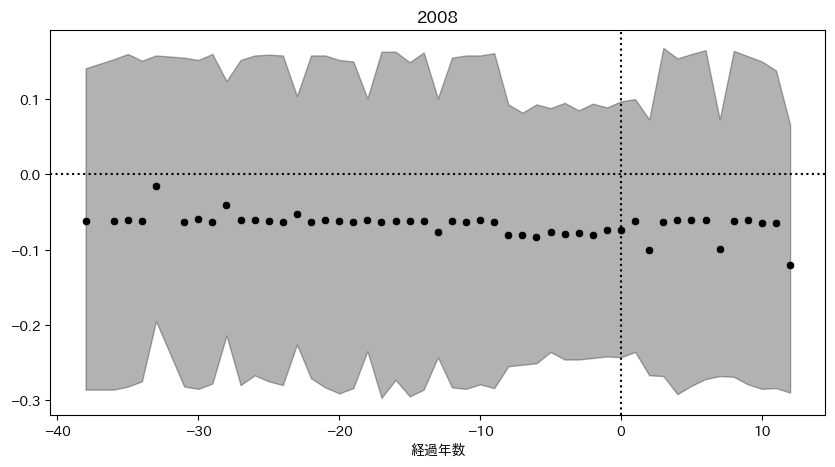

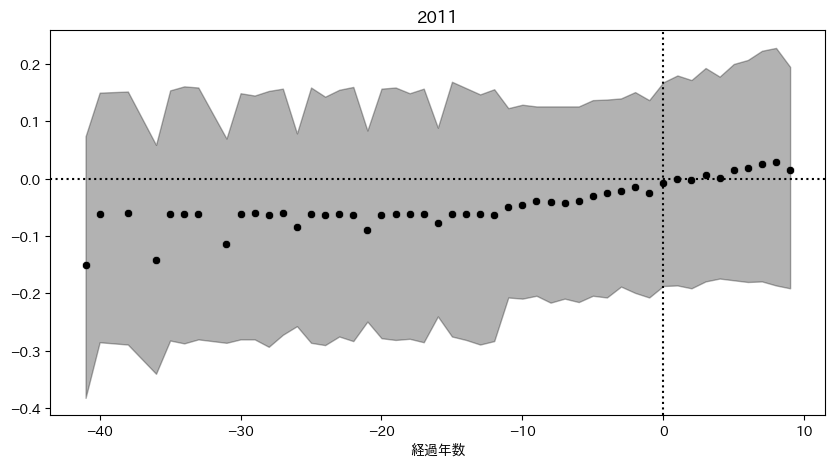

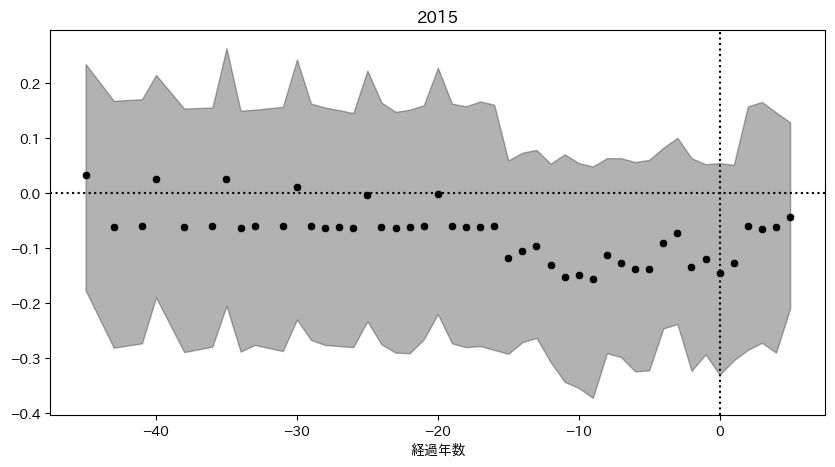

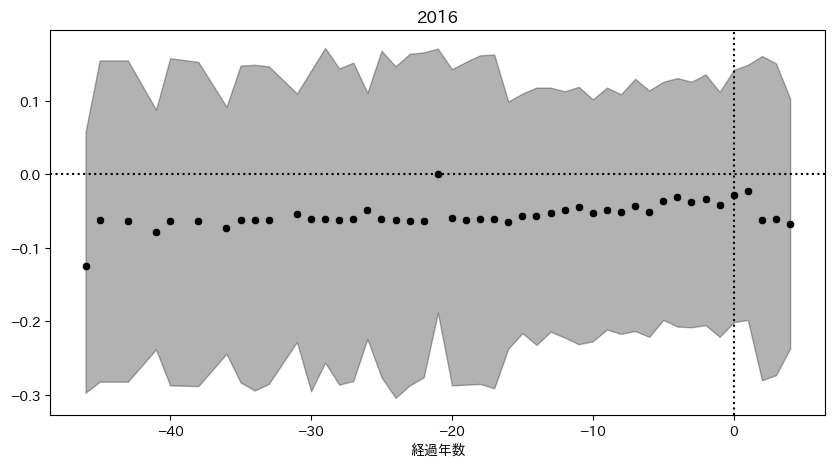

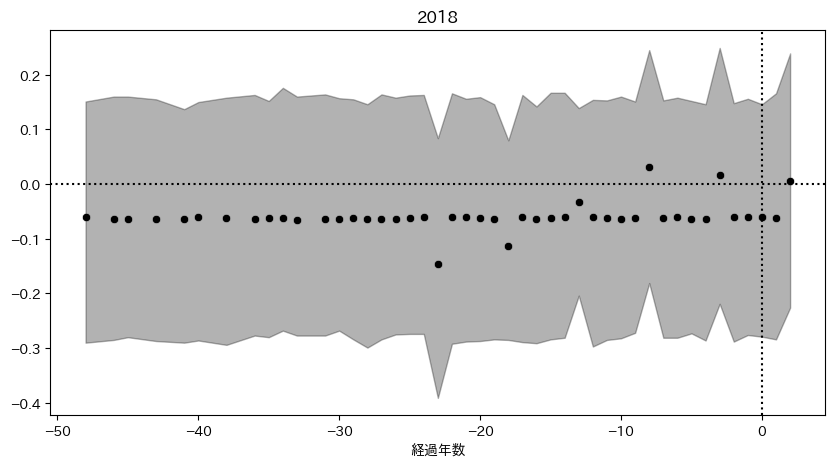

In [71]:
bridge_years = df['bridge_year'].unique()
bridge_years.sort()
for bridge_year in bridge_years:
    beta = FullySaturatedPlotter(df, beta_df, bridge_year)
    beta.fully_saturated_plot()